#Install unzip and extract archive.zip

In [ ]:
!!apt install unzip

['',
 'Reading package lists... 0%',
 '',
 'Reading package lists... 0%',
 '',
 'Reading package lists... 0%',
 '',
 'Reading package lists... 5%',
 '',
 'Reading package lists... 5%',
 '',
 'Reading package lists... 6%',
 '',
 'Reading package lists... 6%',
 '',
 'Reading package lists... 54%',
 '',
 'Reading package lists... 54%',
 '',
 'Reading package lists... 55%',
 '',
 'Reading package lists... 55%',
 '',
 'Reading package lists... 65%',
 '',
 'Reading package lists... 65%',
 '',
 'Reading package lists... 66%',
 '',
 'Reading package lists... 66%',
 '',
 'Reading package lists... 66%',
 '',
 'Reading package lists... 76%',
 '',
 'Reading package lists... 76%',
 '',
 'Reading package lists... 76%',
 '',
 'Reading package lists... 76%',
 '',
 'Reading package lists... 76%',
 '',
 'Reading package lists... 76%',
 '',
 'Reading package lists... 76%',
 '',
 'Reading package lists... 76%',
 '',
 'Reading package lists... 84%',
 '',
 'Reading package lists... 84%',
 '',
 'Reading pack

In [44]:
!unzip  archive.zip -d leaf-data

Archive:  archive.zip
  inflating: leaf-data/test/leaf/TEST_001.jpg  
  inflating: leaf-data/test/leaf/TEST_002.jpg  
  inflating: leaf-data/test/leaf/TEST_003.jpg  
  inflating: leaf-data/test/leaf/TEST_004.jpg  
  inflating: leaf-data/test/leaf/TEST_005.jpg  
  inflating: leaf-data/test/leaf/TEST_006.jpg  
  inflating: leaf-data/test/leaf/TEST_007.jpg  
  inflating: leaf-data/train.csv     
  inflating: leaf-data/train/LEAF_0009.jpg  
  inflating: leaf-data/train/LEAF_0010.jpg  
  inflating: leaf-data/train/LEAF_0011.jpg  
  inflating: leaf-data/train/LEAF_0012.jpg  
  inflating: leaf-data/train/LEAF_0013.jpg  
  inflating: leaf-data/train/LEAF_0014.jpg  
  inflating: leaf-data/train/LEAF_0015.jpg  
  inflating: leaf-data/train/LEAF_0016.jpg  
  inflating: leaf-data/train/LEAF_0017.jpg  
  inflating: leaf-data/train/LEAF_0018.jpg  
  inflating: leaf-data/train/LEAF_0019.jpg  
  inflating: leaf-data/train/LEAF_0020.jpg  
  inflating: leaf-data/train/LEAF_0021.jpg  
  inflating: leaf-d

#Install torchvision and albumentation

In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 32kB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [ ]:
!pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 9.1MB/s 
     |████████████████████████████████| 952kB 14.7MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65164 sha256=232e230b080807621db6db3df4e5a3cc5474775c9b66f1c210d59edd5ecb2476
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


#Imports and setup CUDA for CPU

In [45]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import imageio


from PIL import Image

import time

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.pytorch import transforms

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler


In [46]:

from matplotlib import pyplot as plt
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


DIR_INPUT = 'leaf-data'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

# Loading the device now
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Found GPU at: /device:GPU:0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12343637205553290930, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14000088704
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14133713630568187641
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

# Reading and parsing the CSV

In [47]:
train_df = pd.read_csv(os.path.join(DIR_INPUT,"train.csv"))


In [48]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

In [49]:
image_ids = train_df['image_id'].unique()
#last 4 
valid_ids = image_ids[-4:]

#first 4
valid_ids = np.append(valid_ids,image_ids[:4])
#between them
train_ids = image_ids[4:-4]

valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

valid_df.shape, train_df.shape

['LEAF_1112.jpg' 'LEAF_1113.jpg' 'LEAF_1114.jpg' 'LEAF_1115.jpg'
 'LEAF_0009.jpg' 'LEAF_0010.jpg' 'LEAF_0011.jpg' 'LEAF_0012.jpg']


((195, 7), (5151, 7))

In [65]:
class LeafDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)                
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)
        image = np.reshape(image,image.shape+(1,))

        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [67]:
# This Albumentation for now it is empty.
def transform():
    return A.Compose([ToTensorV2(p=1.0),], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


def collate_fn(batch):
    return tuple(zip(*batch))

In [68]:
train_dataset = LeafDataset(train_df, DIR_TRAIN, transform())
valid_dataset = LeafDataset(valid_df, DIR_TRAIN, transform())


train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn
)


In [69]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


In [70]:
# HELPER FUNCTIONS FOR VIZUALISING / PREDICTING
from sklearn.metrics import average_precision_score

def get_boxes(tensor,index,score=0.9):

    if index >= len(tensor)  or index<0:
        return 0

    true_positive = 0
    false_positive = 0

    temp_boxes = []
    for i in range(len(tensor[index]['boxes'])):
        if tensor[index]['scores'][i] > score:
            true_positive = true_positive + 1
            temp_boxes.append(tensor[index]['boxes'][i].cpu().detach().numpy().astype(np.int32))    
        else:
            false_positive = false_positive + 1 
    
    average_precision = ((true_positive)/(true_positive + false_positive))*1.0
    
    print("Average precision is : ",average_precision)    
    return temp_boxes    

def get_sample_image(itr):
    images, targets, image_ids = next(it)
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[0].permute(1,2,0).cpu().numpy()
    sample = np.reshape(sample,(sample.shape[1],sample.shape[1]))
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
    for box in boxes:
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      0, 2)

    ax.set_axis_off()
    ax.imshow(sample,cmap='gray')

def get_validation_image(itr):
    images, targets, image_ids = next(itr)
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    num_image = len(images)

    for index in range(num_image):

      boxes_from_csv = targets[index]['boxes'].cpu().numpy().astype(np.int32)
      sample_from_csv = images[index].permute(1,2,0).cpu().numpy()
      sample_from_csv = np.reshape(sample_from_csv,(sample_from_csv.shape[1],sample_from_csv.shape[1]))
      fig, ax_from_csv = plt.subplots(1, 1, figsize=(16, 8))
         
      for box in boxes_from_csv:
          cv2.rectangle(sample_from_csv,
                        (box[0], box[1]),
                        (box[2], box[3]),
                        0, 2)
      ax_from_csv.title.set_text("Boxes from labeled data file")
      ax_from_csv.imshow(sample_from_csv,cmap='gray')

      model.eval()

      outputs = model(images)
      outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]

      # boxes = get_boxes(outputs,index)
      boxes_from_model = outputs[index]['boxes'].cpu().detach().numpy().astype(np.int32)

      sample = images[index].permute(1,2,0).cpu().numpy()
      boxes = get_boxes(outputs,index)

      sample = images[index].permute(1,2,0).cpu().numpy()
      sample = np.reshape(sample,(sample.shape[1],sample.shape[1]))
      fig, ax = plt.subplots(1, 1, figsize=(16, 8))
      
      for box in boxes:
          cv2.rectangle(sample,
                        (box[0], box[1]),
                        (box[2], box[3]),
                        0, 2)
      ax.title.set_text("Boxes from model")
      ax.imshow(sample,cmap='gray')
    
def load_test_dataset(data_path_param):
    data_path = data_path_param

    test_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        
        transform=torchvision.transforms.Compose([
            torchvision.transforms.Grayscale(num_output_channels=1),
            torchvision.transforms.ToTensor(),]
    ))
    
    test_loader = torch.utils.data.DataLoader(    
        test_dataset,
        batch_size=1,
        num_workers=1,
        shuffle=False
    )
    return test_loader

def get_test_image(itr,score = 0.9):
    image, targets= next(itr)
    sample = image
    
    image = image.to(device)
    model.eval()
    outputs = model(image)
    
    outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]   
    
    boxes = get_boxes(outputs,0,score)
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    img = sample[0].permute(1,2,0).cpu().numpy()

    img = np.array(img)
    img = np.reshape(img,(img.shape[1],img.shape[1]))

    for box in boxes:
        x,y,w,h = box
        
        cv2.rectangle(np.float32(img),
                      (int(box[0]), int(box[1])),
                      (int(box[2]), int(box[3])),
                      0, 2)
    ax.set_axis_off()
    ax.imshow(img,cmap='gray')

def process_image(itr,index, score = 0.9):
    
    image, targets= next(itr)
    sample = image

    if image.shape[2]>image.shape[3]:
      new_size = image.shape[3] 
    else:
      new_size = image.shape[2]
      
    names_dir = ['name','x','y','w','h']
    df = pd.DataFrame([], columns=names_dir)

    images_dir = os.listdir('data/leaf')
    images_dir_name = images_dir[index]
    
    image = image.to(device)
    model.eval()
    outputs = model(image)
    outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]   
    
    boxes = get_boxes(outputs,0,score)
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    img = sample[0].permute(1,2,0).cpu().numpy()

    img = np.array(img)
    img = np.reshape(img,(img.shape[1],img.shape[1]))
    
    for box in boxes:
        x,y,w,h = box

        cv2.rectangle(np.float32(img),
                      (int(box[0]), int(box[1])),
                      (int(box[2]), int(box[3])),
                      0, 2)

        vector = [images_dir_name,x,y,w,h]

        df_temp = pd.DataFrame([vector],columns=names_dir)
        df = df.append(df_temp)


    df.to_csv(images_dir_name.split('.')[0] + '_coord.csv')
  
    # ax.set_axis_off()
    ax.imshow(img,cmap = 'gray')

# Sample of training data augumented


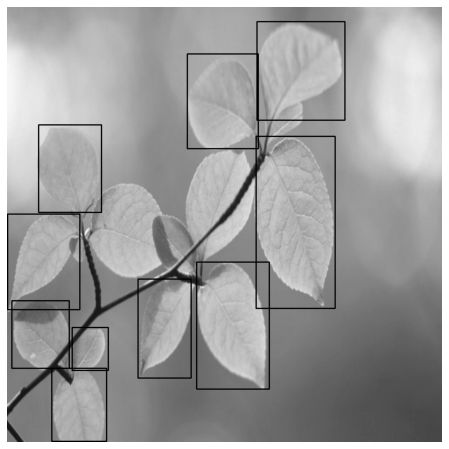

In [74]:
it = iter(train_data_loader)
get_sample_image(it)

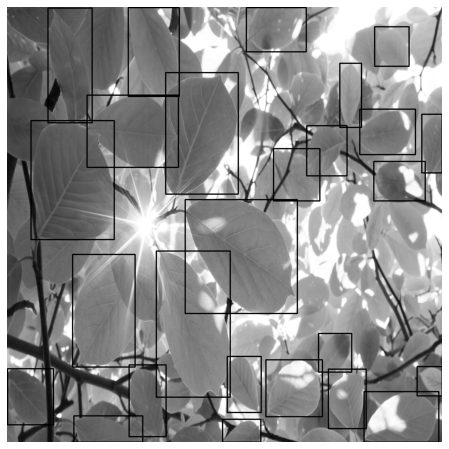

In [75]:
get_sample_image(it)

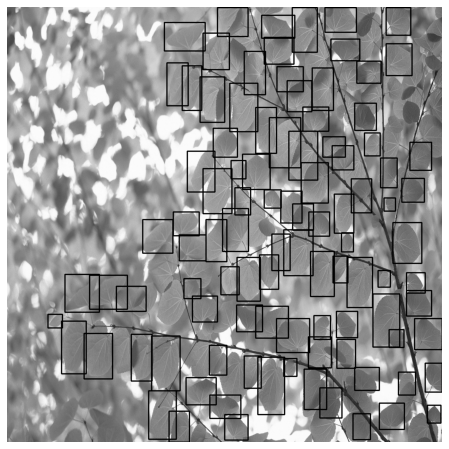

In [76]:
get_sample_image(it)

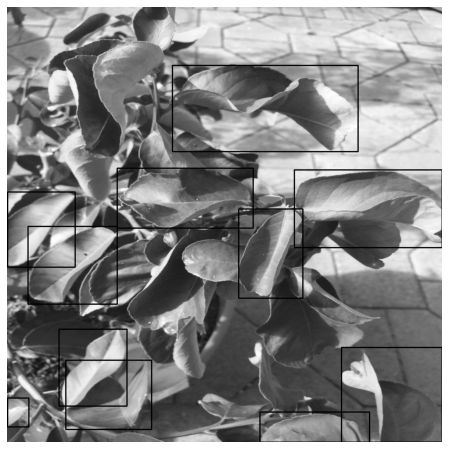

In [77]:
get_sample_image(it)

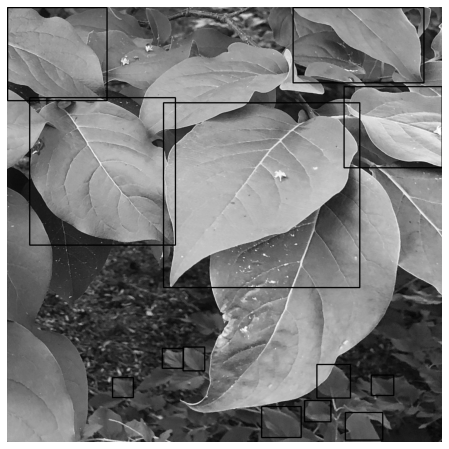

In [78]:
get_sample_image(it)

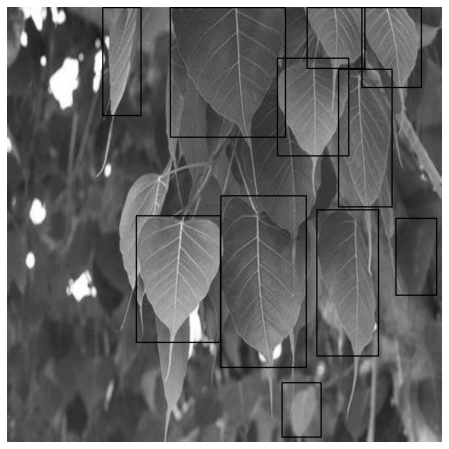

In [79]:
get_sample_image(it)

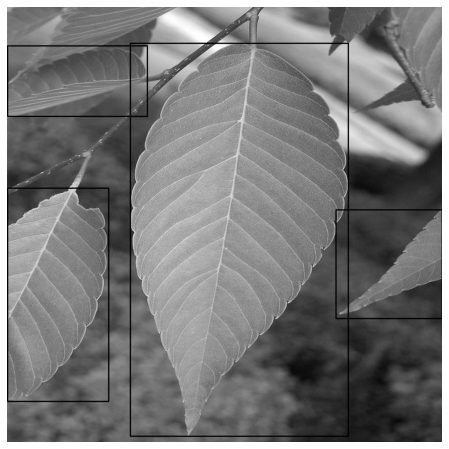

In [80]:
get_sample_image(it)

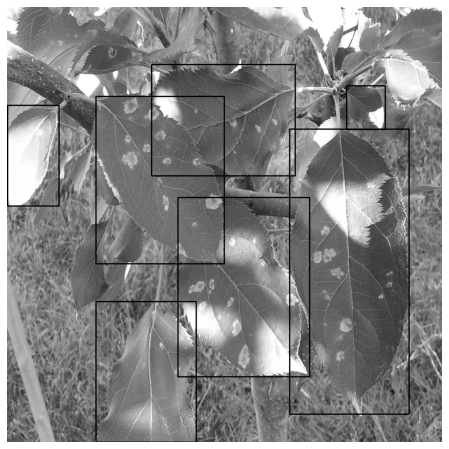

In [81]:
get_sample_image(it)

In [82]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [83]:

num_classes = 2  # 1 class (leaf) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [84]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

# Training

In [71]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# lr_scheduler = None
num_epochs = 15

In [72]:
loss_hist = Averager()
itr = 1

previous_epoch = 1000
es_rate = 0

es_threshold = 2 # How many epochs without improvement to early stop

for epoch in range(num_epochs):
    loss_hist.reset()
    min_loss = 1000
    for images, targets, image_ids in train_data_loader:

        images = list(image.to(device) for image in images)

        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")
        
        itr += 1
                
            
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    min_loss = loss_hist.value
    
    if min_loss < previous_epoch:
        previous_epoch = min_loss
        es_rate = 0
        
    else:
        if es_rate < es_threshold:
            es_rate += 1
        elif es_rate >= es_threshold:
            break
    print(f"Epoch #{epoch} loss: {loss_hist.value}")   


Iteration #50 loss: 0.19934692978858948
Iteration #100 loss: 0.39945757389068604
Iteration #150 loss: 0.5298100709915161
Iteration #200 loss: 0.13747641444206238
Iteration #250 loss: 0.2572554647922516
Epoch #0 loss: 0.2987553378918417
Iteration #300 loss: 0.3861042857170105
Iteration #350 loss: 0.2182914912700653
Iteration #400 loss: 0.28770771622657776
Iteration #450 loss: 0.1799716204404831
Iteration #500 loss: 0.2786802649497986
Iteration #550 loss: 0.21451953053474426
Epoch #1 loss: 0.24488190416365968
Iteration #600 loss: 0.13688743114471436
Iteration #650 loss: 0.44744864106178284
Iteration #700 loss: 0.07001783698797226
Iteration #750 loss: 0.3188665807247162
Iteration #800 loss: 0.10762909054756165
Epoch #2 loss: 0.20812148826853025
Iteration #850 loss: 0.33359354734420776
Iteration #900 loss: 0.2833716571331024
Iteration #950 loss: 0.23376165330410004
Iteration #1000 loss: 0.09628783911466599
Iteration #1050 loss: 0.16338811814785004
Iteration #1100 loss: 0.08423034101724625


In [73]:
print(loss_dict)

{'loss_classifier': tensor(0.1084, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.1060, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0032, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0331, device='cuda:0', grad_fn=<DivBackward0>)}


# Validation (On data from Training)

In [96]:
model = torch.load('leaves_fasterrcnn_model_15epoch.h5')

In [97]:
it = iter(valid_data_loader)

Average precision is :  0.3333333333333333
Average precision is :  0.05
Average precision is :  0.6363636363636364
Average precision is :  0.125


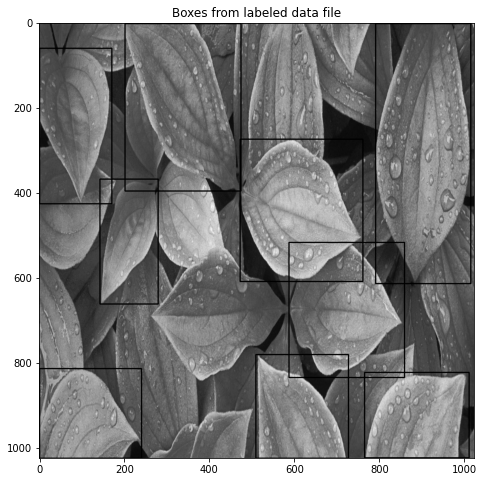

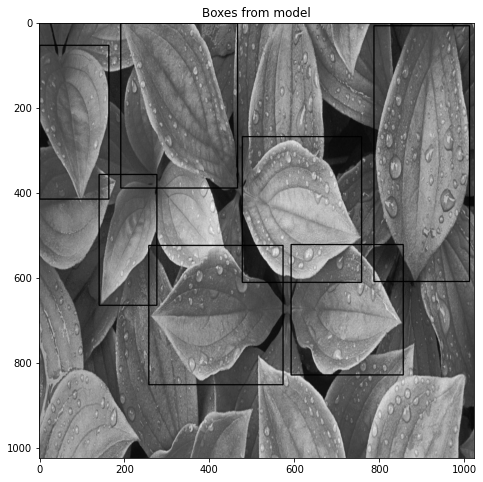

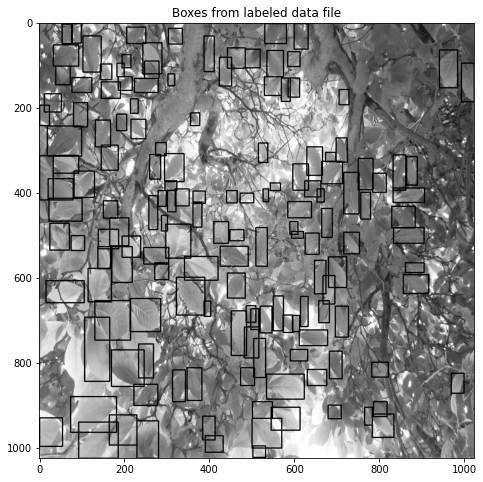

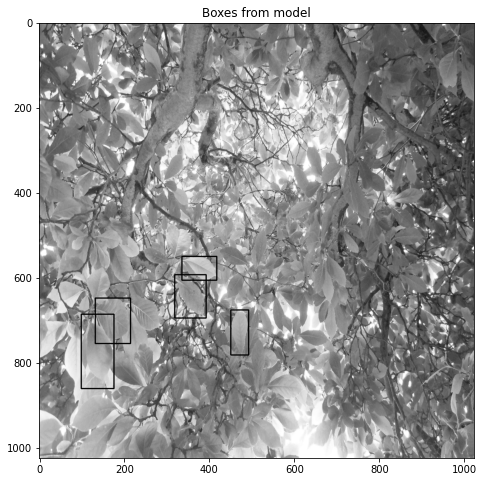

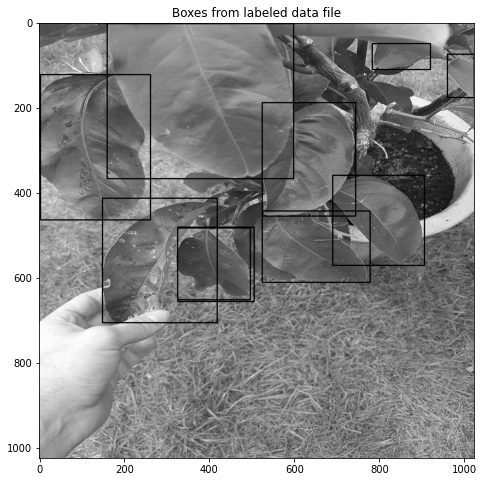

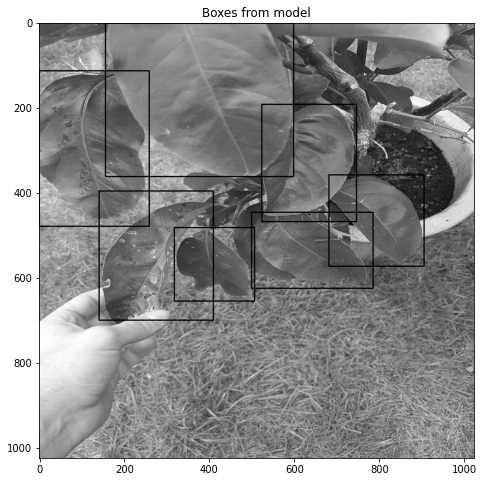

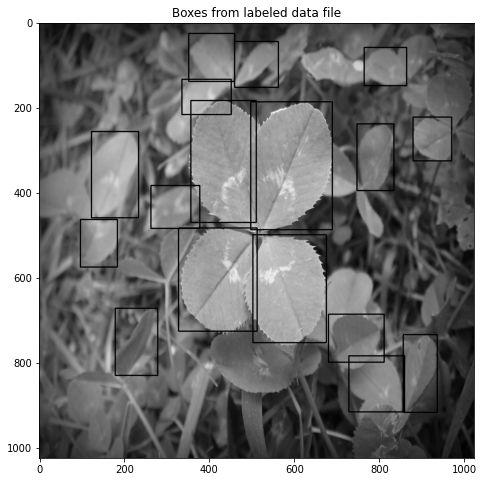

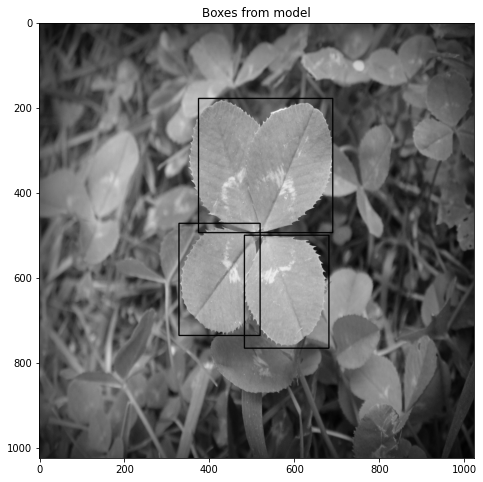

In [98]:
get_validation_image(it)

Average precision is :  0.75
Average precision is :  1.0
Average precision is :  1.0
Average precision is :  0.4


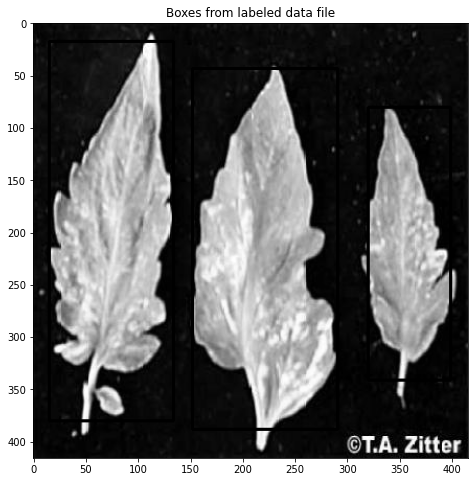

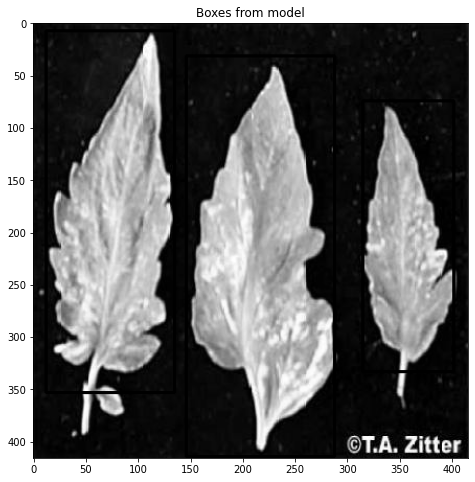

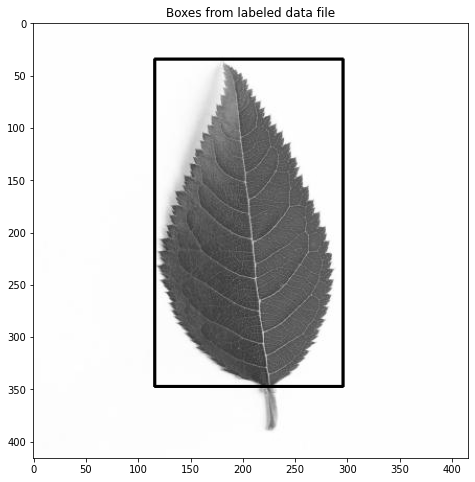

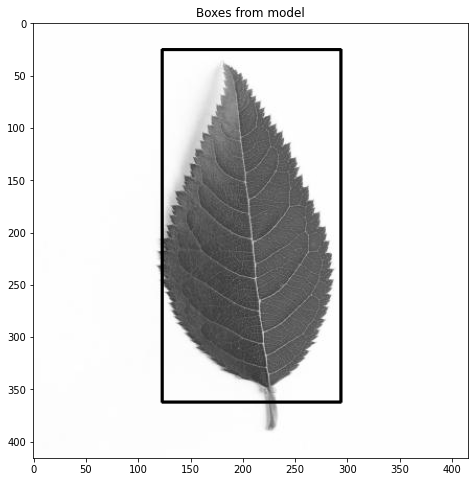

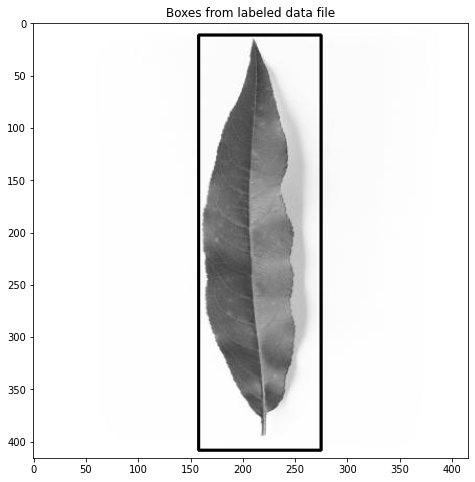

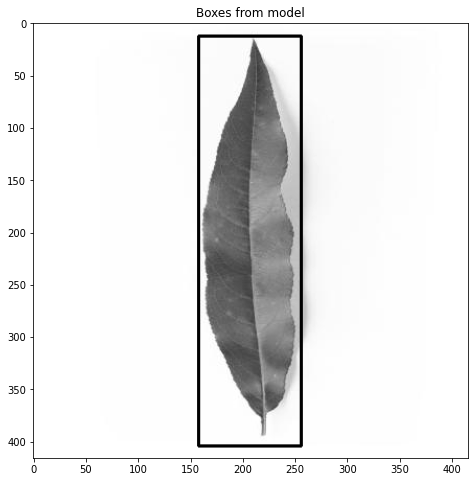

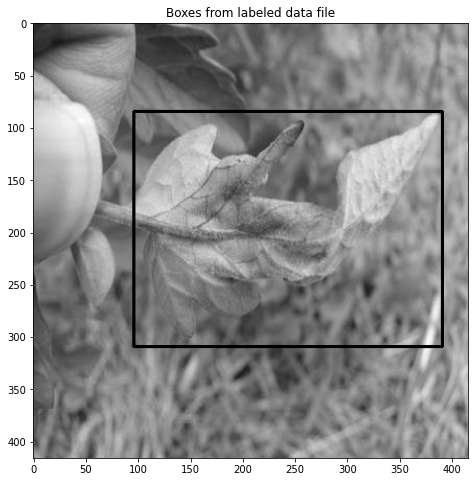

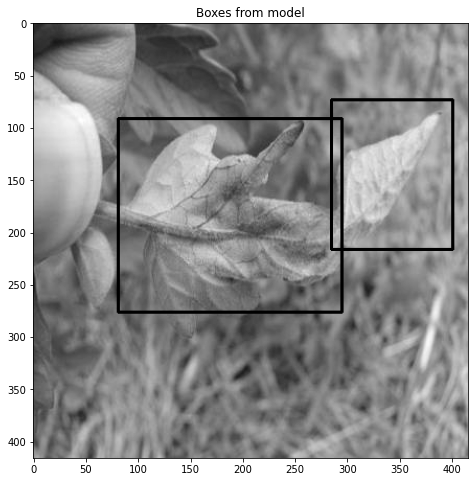

In [99]:
get_validation_image(it)

# Testing

In [108]:
image_list = os.listdir(DIR_TEST+"/leaf")
print(image_list)

['TEST_003.jpg', 'TEST_002.jpg', 'TEST_004.jpg', 'TEST_006.jpg', 'TEST_007.jpg', 'TEST_001.jpg', 'TEST_005.jpg']


In [109]:
it = iter(load_test_dataset('/content/leaf-data/test'))


Average precision is :  0.02
0.1749861240386963


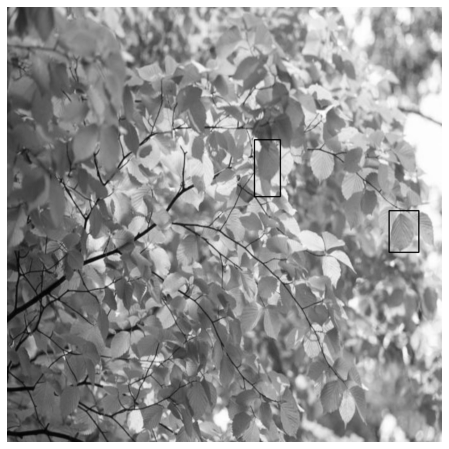

In [110]:
start = time.time()
get_test_image(it)
print(time.time()-start)

Average precision is :  0.1
0.16644048690795898


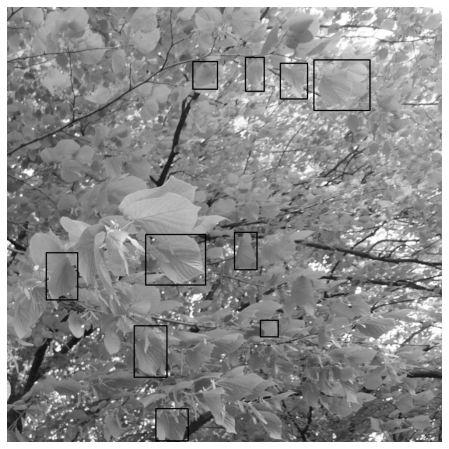

In [111]:
start = time.time()
get_test_image(it,0.8)
print(time.time()-start)

Average precision is :  0.47619047619047616
0.1589806079864502


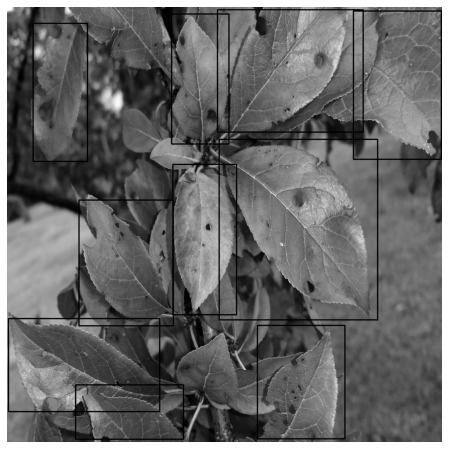

In [112]:
start = time.time()
get_test_image(it,0.9)
print(time.time()-start)

Average precision is :  0.2112676056338028
0.15846776962280273


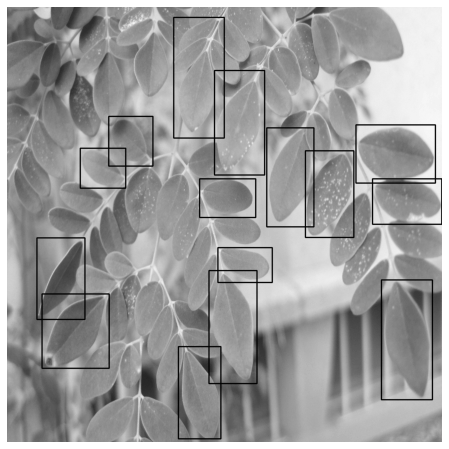

In [113]:
start = time.time()
get_test_image(it)
print(time.time()-start)

Average precision is :  0.27906976744186046
0.15875864028930664


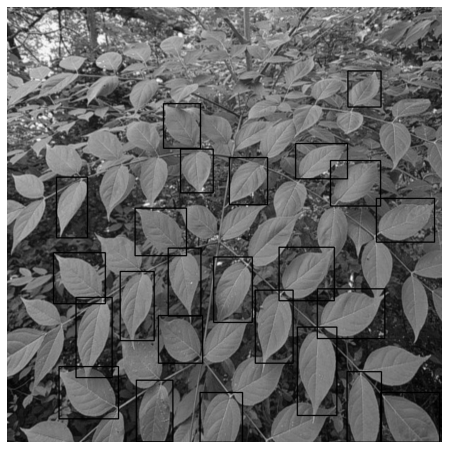

In [114]:
start = time.time()
get_test_image(it,0.9)
print(time.time()-start)

#Save model

In [ ]:
!pip install pyyaml h5py

In [ ]:
print(tf.version.VERSION)

2.4.1


In [ ]:
#save as a hdf5
torch.save(model, 'leaves_fasterrcnn_model_15epoch.h5')

In [ ]:
torch.save(model, 'leaves_fasterrcnn_model_15_epoch.pth')

In [ ]:
filename = 'final_model_15epoch.sav'

In [ ]:
torch.save(model, filename)

In [ ]:
from keras.models import load_model
# model = load_model('/content/leaves_fasterrcnn_model_15_epoch.pth')
# print("Model loaded")

#Read model and process data

In [129]:
model = torch.load('leaves_fasterrcnn_model_15epoch.h5')

In [130]:
one_image = os.listdir('/content/data/leaf')
print(one_image)
num_image = len(one_image)

['acer-buergerianum-trident-maple-branch-tip-with-three-lobed-and-toothed-green-leaves-and-cluster-of-green-flowers-PFPF6N.jpg', 'ChineseTulipTree.jpg', 'Tangerine.jpg', 'Redbud.jpg', 'TridentMaple.jpg', 'CanadianPoplar.jpg', 'TrueIndigo.jpg', 'Peach.jpg', '.ipynb_checkpoints']


In [131]:
data_for_process = iter(load_test_dataset('data'))

Average precision is :  1.0
0.18737506866455078
Average precision is :  0.5
0.11732912063598633
Average precision is :  1.0
0.11891984939575195
Average precision is :  0.7272727272727273
0.1167154312133789
Average precision is :  0.5
0.10341620445251465
Average precision is :  0.42857142857142855
0.10589909553527832
Average precision is :  0.8333333333333334
0.10709929466247559
Average precision is :  0.5
0.10895013809204102


StopIteration: ignored

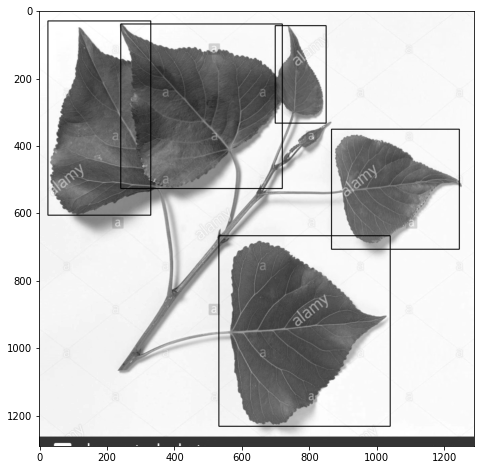

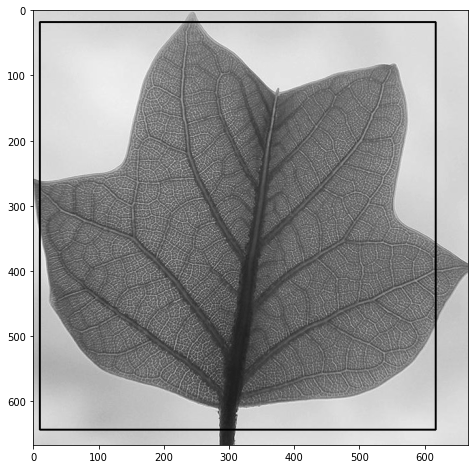

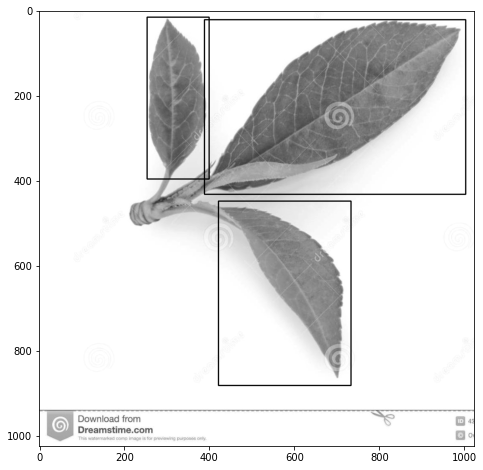

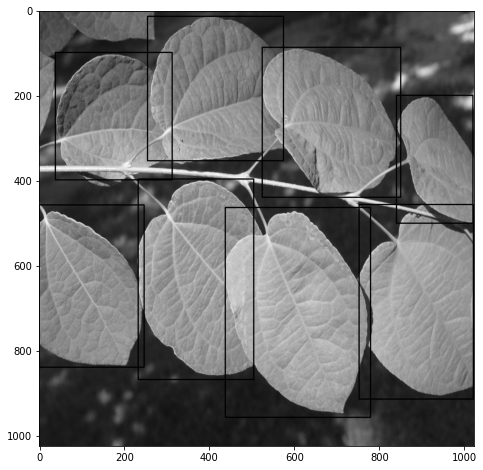

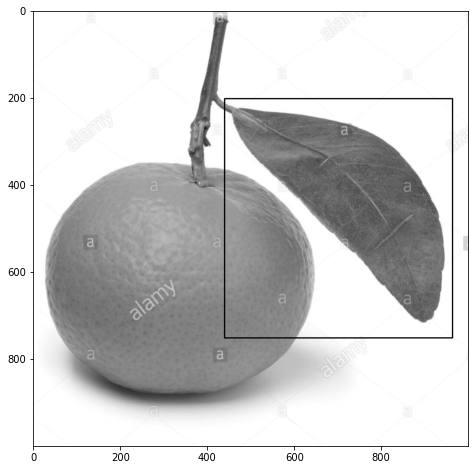

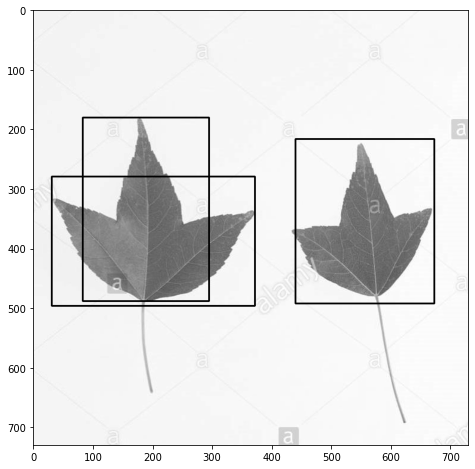

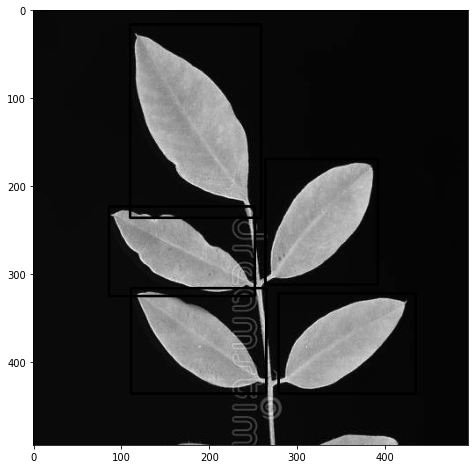

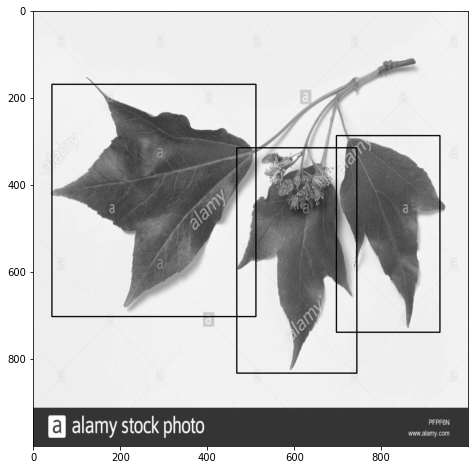

In [132]:

for i in range(num_image):
  start = time.time()
  process_image(data_for_process,i)
  print(time.time()-start)